                                    feature  importance
43                        HbA1c_high_change    0.000514
50                 AdmissionSource_referral    0.000498
44                     HbA1c_high_no_change    0.000481
10                            race_Hispanic    0.000408
20                              age_[60-70)    0.000310
41                    PrimaryDiagnose_Other    0.000294
48                        Discharge_to_home    0.000286
40                PrimaryDiagnose_Neoplasms    0.000277
55  MedicalSpecialty_Family/GeneralPractice    0.000204
56        MedicalSpecialty_InternalMedicine    0.000188


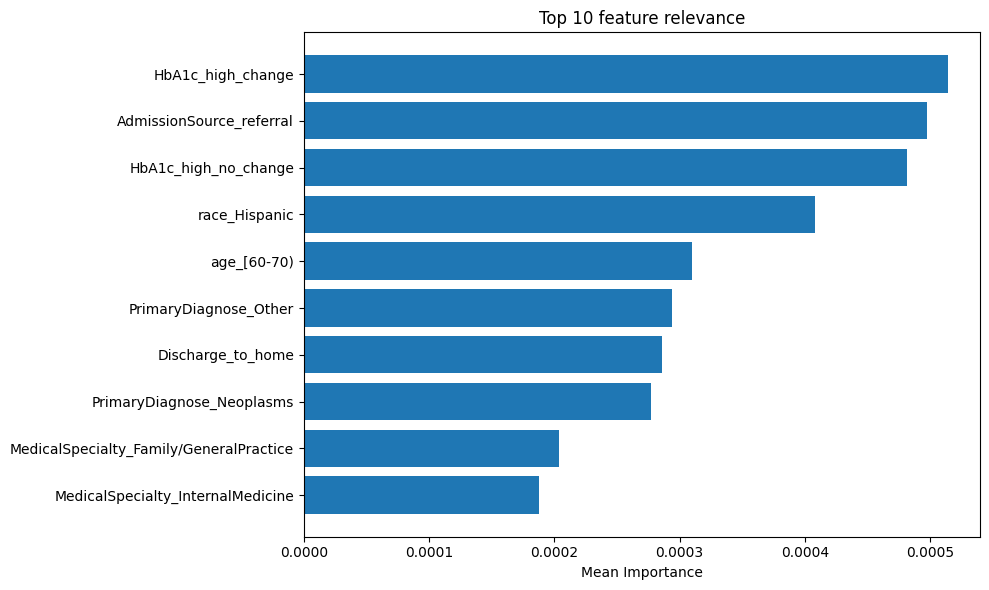

In [2]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier

final_dta = pd.read_csv("data_preprocessed.csv")

X = final_dta.drop(columns="target")
y = final_dta["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

best_model = joblib.load("best_model.pkl")
preprocessor = best_model.named_steps["preprocessor"]

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

# Resample training data again (similar to the best model from ML_model.py)
smote = SMOTE(sampling_strategy=0.1, k_neighbors=5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train_pre, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [col for col in X.columns if col not in num_features]
cat_features = preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_cols)

feature_names = num_features + list(cat_features)

result = permutation_importance(model, X_test_pre, y_test, n_repeats=10, random_state=42, n_jobs=-1)

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": result.importances_mean
}).sort_values(by="importance", ascending=False)

print(feat_imp.head(10))

#plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["feature"][:10][::-1], feat_imp["importance"][:10][::-1])
plt.title("Top 10 feature relevance")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()
